In [1]:
import ctree
import cstructures
import numpy as np
import sejits_recon
import pyop
from pyop import matvectorized
from numpy import tile
from scipy.io import loadmat
import matplotlib.pyplot as plt
from dc_removal.dc_rem_specializer import dcRemoval as dcRemSejits

%matplotlib inline

In [2]:
def dcRemoval(block_set, height, length):

    @matvectorized((height, -1), order='F')
    def dcRem(block_set):

        print "Beginning of dc Rem shape: ", block_set.shape
        # Partial field of views, one per row
        pfovs = block_set.reshape((-1, length))

        # Sum across rows to get the average of each pfov.
        dc_values = pfovs.sum(1) / length

        # Tiling to apply DC removal to each point in each pfov.
        # Transpose due to tile treating 1D as a row vector.
        dc_values_rep = tile(dc_values, (length, 1)).T

        # Reshape into the blocks_set image. Turn to column format
        return (pfovs - dc_values_rep).reshape((height, -1))

    return dcRem(block_set)

Height:  64
pfov_len:  52
pfov_num:  3


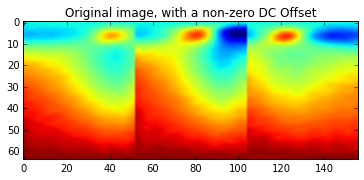

In [3]:
# With the image
img_data = loadmat("z_plane_rt.mat", squeeze_me=True)
img = img_data['pfov_images'][0]

img_height = img_data['image_shape'][0]
pfov_len = img_data['pfov_width']
pfov_num = img_data['pfov_num']

# Create a DC offset to deal with this image
dc_offset = np.array([[i * 0.002] * pfov_len * pfov_num for i in range(img_height)])

# Redefine the image to account for the DC offset
img = img + dc_offset

print "Height: ", img_height
print "pfov_len: ", pfov_len
print "pfov_num: ", pfov_num 

plt.title("Original image, with a non-zero DC Offset")
plt.imshow(img)

Beginning of dc Rem shape:  (64, 156)


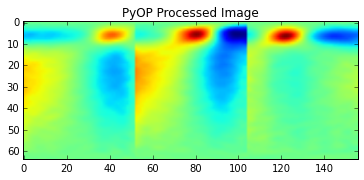

In [4]:
# Any function decorated by @matvectorized must take in a 1D vector.
result_img = dcRemoval(img.flatten(1), img_height, pfov_len) # NOTE: you have to flatten along dimension 1
result_img = result_img.reshape(img.shape, order='F') # the shape has to be the opposite of the input image (thus, the fortran ordering)

plt.title("PyOP Processed Image")
plt.imshow(result_img)

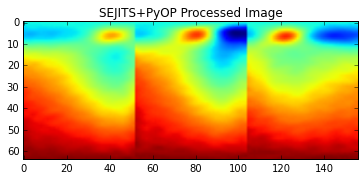

In [5]:
sejits_img = cstructures.Array.array(img.flatten())
sejits_result = np.array(dcRemSejits(sejits_img, int(pfov_len), int(img_height)))
sejits_result = sejits_result.reshape(img.shape, order='C') # the shape has to be the opposite of the input image (thus, the fortran ordering)

plt.title("SEJITS+PyOP Processed Image")
plt.imshow(sejits_result)

In [6]:
test_arr = cstructures.Array.array(list(range(50)))
print test_arr
sejits_result = np.array(dcRemSejits(test_arr, int(5), int(10)))
print sejits_result


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]


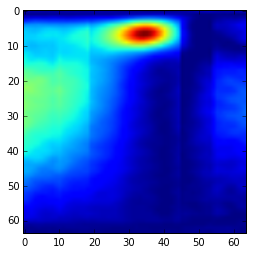

In [12]:
pyop_img_data = loadmat("dc_optim_recon_pyop.mat", squeeze_me=True)
plt.imshow(pyop_img_data["image"][:, :, 0])

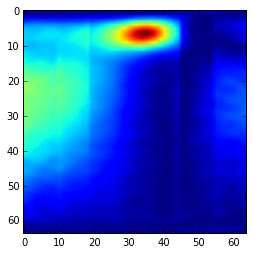

In [13]:
sejits_img_data = loadmat("dc_optim_recon_sejits.mat", squeeze_me=True)
plt.imshow(sejits_img_data["image"][:, :, 0])